# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV

# Load Files: All

In [2]:
df = pd.read_excel('Data_Train.xlsx')
# validation_df = pd.read_excel('Test_set.xlsx')

# File: Data_Train

In [3]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


### Missing Values

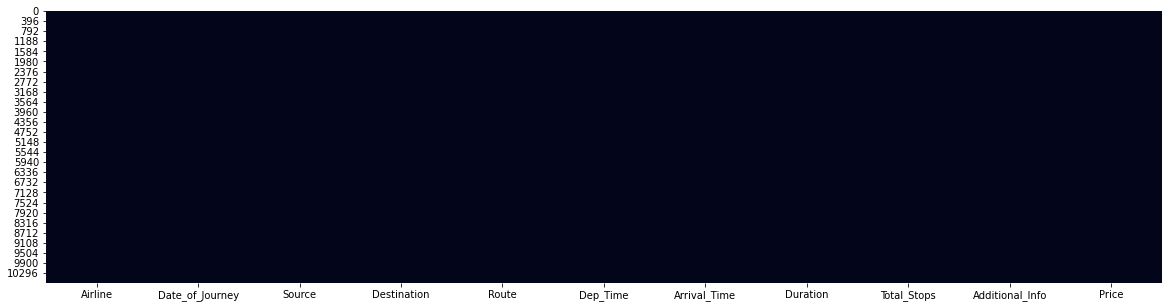

In [5]:
plt.figure(figsize=(20,5))
sns.heatmap(df.isnull(), cbar=False)
plt.show()

In [6]:
df.isna().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [7]:
df[df['Total_Stops'].isna()]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,No info,7480


In [8]:
df.dropna(inplace=True)

In [9]:
df.isna().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

### Target: Price

### Refactoring

- Transform columns of 'Date_of_Journey', 'Dep_Time', 'Arrival_Time' to datime data type

In [10]:
def change_into_datetime(df, col):
    df[col] = pd.to_datetime(df[col])

In [11]:
df.dtypes

Airline            object
Date_of_Journey    object
Source             object
Destination        object
Route              object
Dep_Time           object
Arrival_Time       object
Duration           object
Total_Stops        object
Additional_Info    object
Price               int64
dtype: object

In [12]:
for col in ['Date_of_Journey', 'Dep_Time', 'Arrival_Time']:
    change_into_datetime(df, col)

In [13]:
df.dtypes

Airline                    object
Date_of_Journey    datetime64[ns]
Source                     object
Destination                object
Route                      object
Dep_Time           datetime64[ns]
Arrival_Time       datetime64[ns]
Duration                   object
Total_Stops                object
Additional_Info            object
Price                       int64
dtype: object

In [14]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,2021-05-08 22:20:00,2021-03-22 01:10:00,2h 50m,non-stop,No info,3897
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,2021-05-08 05:50:00,2021-05-08 13:15:00,7h 25m,2 stops,No info,7662
2,Jet Airways,2019-09-06,Delhi,Cochin,DEL → LKO → BOM → COK,2021-05-08 09:25:00,2021-06-10 04:25:00,19h,2 stops,No info,13882
3,IndiGo,2019-12-05,Kolkata,Banglore,CCU → NAG → BLR,2021-05-08 18:05:00,2021-05-08 23:30:00,5h 25m,1 stop,No info,6218
4,IndiGo,2019-01-03,Banglore,New Delhi,BLR → NAG → DEL,2021-05-08 16:50:00,2021-05-08 21:35:00,4h 45m,1 stop,No info,13302


- we separate 'Date_of_Journey' into different columns to be used in the model

In [15]:
df['journey_day'] = df['Date_of_Journey'].dt.day
df['journey_month'] = df['Date_of_Journey'].dt.month
df['journey_year'] = df['Date_of_Journey'].dt.year

df.drop('Date_of_Journey', axis=1, inplace=True)

In [16]:
df['journey_year'].value_counts()

2019    10682
Name: journey_year, dtype: int64

In [17]:
df.drop('journey_year', axis=1, inplace=True)

In [18]:
df.head()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,journey_day,journey_month
0,IndiGo,Banglore,New Delhi,BLR → DEL,2021-05-08 22:20:00,2021-03-22 01:10:00,2h 50m,non-stop,No info,3897,24,3
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2021-05-08 05:50:00,2021-05-08 13:15:00,7h 25m,2 stops,No info,7662,5,1
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2021-05-08 09:25:00,2021-06-10 04:25:00,19h,2 stops,No info,13882,6,9
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,2021-05-08 18:05:00,2021-05-08 23:30:00,5h 25m,1 stop,No info,6218,5,12
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,2021-05-08 16:50:00,2021-05-08 21:35:00,4h 45m,1 stop,No info,13302,3,1


- We extract the hour and minute from the Dep_Time and Arrival_Time columns

In [19]:
for col in ['Dep_Time', 'Arrival_Time']:
    df[col+"_hour"] = df[col].dt.hour
    df[col+"_minute"]=df[col].dt.minute
    df.drop(col, axis=1, inplace=True)

In [20]:
df.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,journey_day,journey_month,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,5,1,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,6,9,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,5,12,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,3,1,16,50,21,35


- We transform the duration feature to a regular format and separate it into hours and minutes.

In [21]:
duration = df['Duration'].to_list()
for i in range(len(duration)):
    if len(duration[i].split(' ')) == 2:
        pass
    else:
        if 'h' in duration[i]:
            duration[i] = duration[i] + ' 0m'
        else:
            duration[i] = '0h ' + duration[i]

df['Duration'] = duration

In [22]:
df.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,journey_day,journey_month,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,5,1,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h 0m,2 stops,No info,13882,6,9,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,5,12,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,3,1,16,50,21,35


In [23]:
def hour(x):
    return int(x.split(' ')[0][0:-1])

def mins(x):
    return int(x.split(' ')[1][0:-1])

In [24]:
df['Duration_hours'] = df['Duration'].apply(hour)
df['Duration_mins'] = df['Duration'].apply(mins)

df.drop('Duration', axis=1, inplace=True)

In [25]:
df.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,journey_day,journey_month,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,Duration_hours,Duration_mins
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,5,1,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,6,9,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,5,12,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info,13302,3,1,16,50,21,35,4,45


## Categorical features

In [26]:
cat_cols = [col for col in df.columns if df[col].dtype == 'O']
cat_cols

['Airline', 'Source', 'Destination', 'Route', 'Total_Stops', 'Additional_Info']

In [27]:
cat_df = df[cat_cols]
cat_df.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info


In [28]:
print('Number of categories by categorical feature: \n')
for i in cat_df.columns:
    print('{} has total {} categories'.format(i, len(cat_df[i].unique())))

Number of categories by categorical feature: 

Airline has total 12 categories
Source has total 5 categories
Destination has total 6 categories
Route has total 128 categories
Total_Stops has total 5 categories
Additional_Info has total 10 categories


### Airline feature

In [29]:
cat_df['Airline'].value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

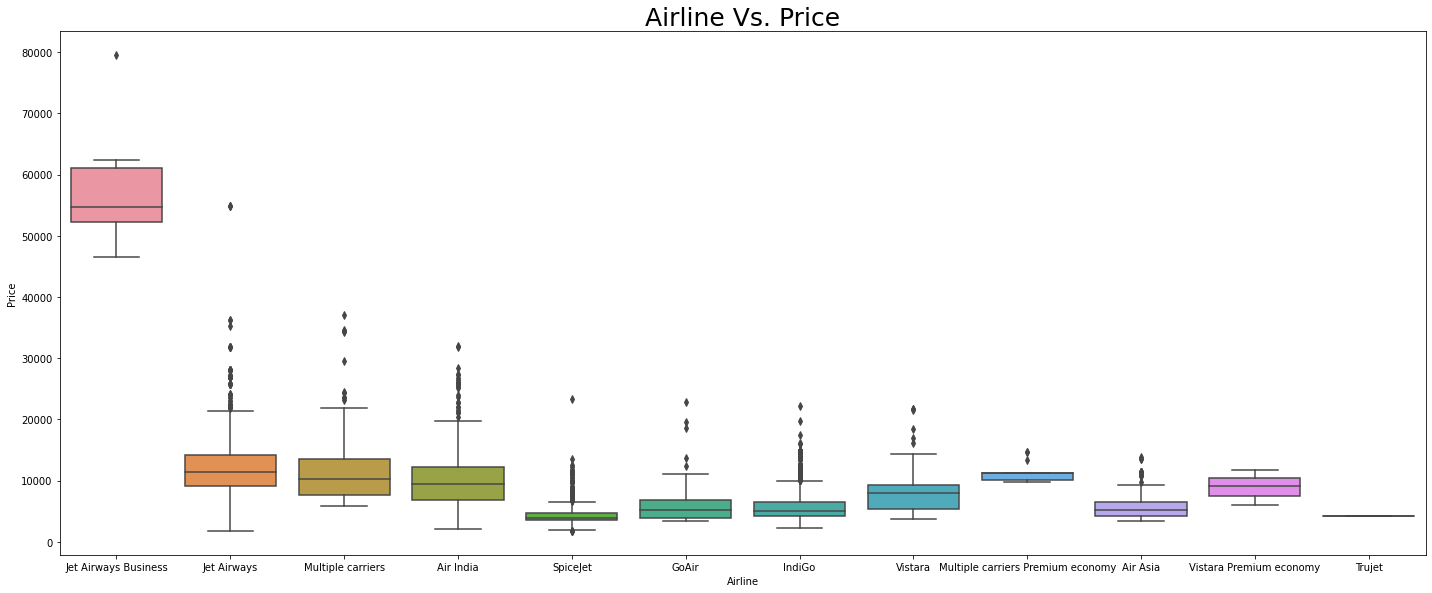

In [30]:
plt.figure(figsize=(20,8))
sns.boxplot(x='Airline', y='Price', data = df.sort_values('Price', ascending=False))
plt.tight_layout()
plt.title('Airline Vs. Price', fontsize=25)
plt.show()

**Insight:**
- Jet Airways Business has the highest price compared to other airlines that have a similar price
- Jet Airways, Multiple Carriers and Air India have a similar distribution in their prices
- Trujet seems to have just one price

In [31]:
airline_df = pd.get_dummies(cat_df['Airline'], drop_first=True)
airline_df.head()

,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Trujet,Vistara,Vistara Premium economy
0,0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0


### Total_Stops

In [32]:
cat_df['Total_Stops'].value_counts()

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

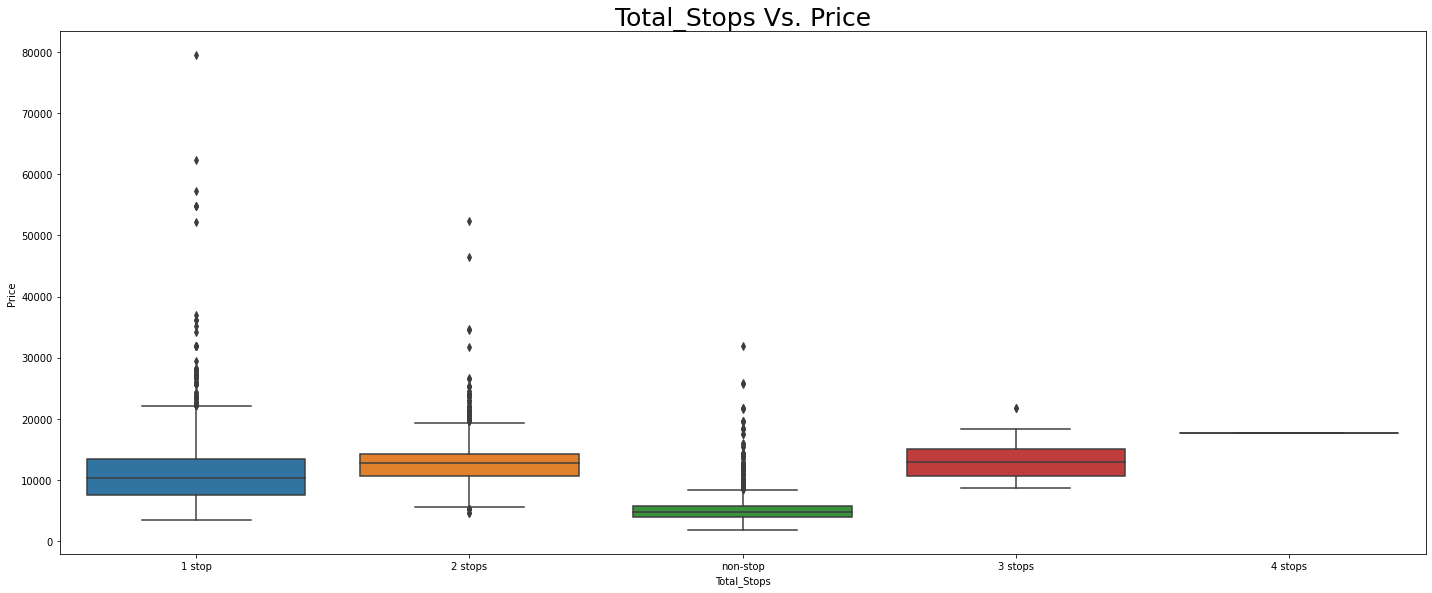

In [33]:
plt.figure(figsize=(20,8))
sns.boxplot(x='Total_Stops', y='Price', data = df.sort_values('Price', ascending=False))
plt.tight_layout()
plt.title('Total_Stops Vs. Price', fontsize=25)
plt.show()

**Insight:**
- 1 stop seems to have has a lot of outliers, what it could means that 1 stop has a higher price that the other stops

In [34]:
cat_df['Total_Stops'].unique()

array(['non-stop', '2 stops', '1 stop', '3 stops', '4 stops'],
      dtype=object)

In [35]:
Total_Stops = {'non-stop':0, '2 stops':2, '1 stop':1, '3 stops':3, '4 stops':4}
cat_df.loc[:,'Total_Stops'] = cat_df.loc[:,'Total_Stops'].map(Total_Stops).copy()

In [36]:
cat_df.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info
0,IndiGo,Banglore,New Delhi,BLR → DEL,0,No info
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2,No info
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2,No info
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1,No info
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1,No info


### Source

In [37]:
cat_df['Source'].value_counts()

Delhi       4536
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: Source, dtype: int64

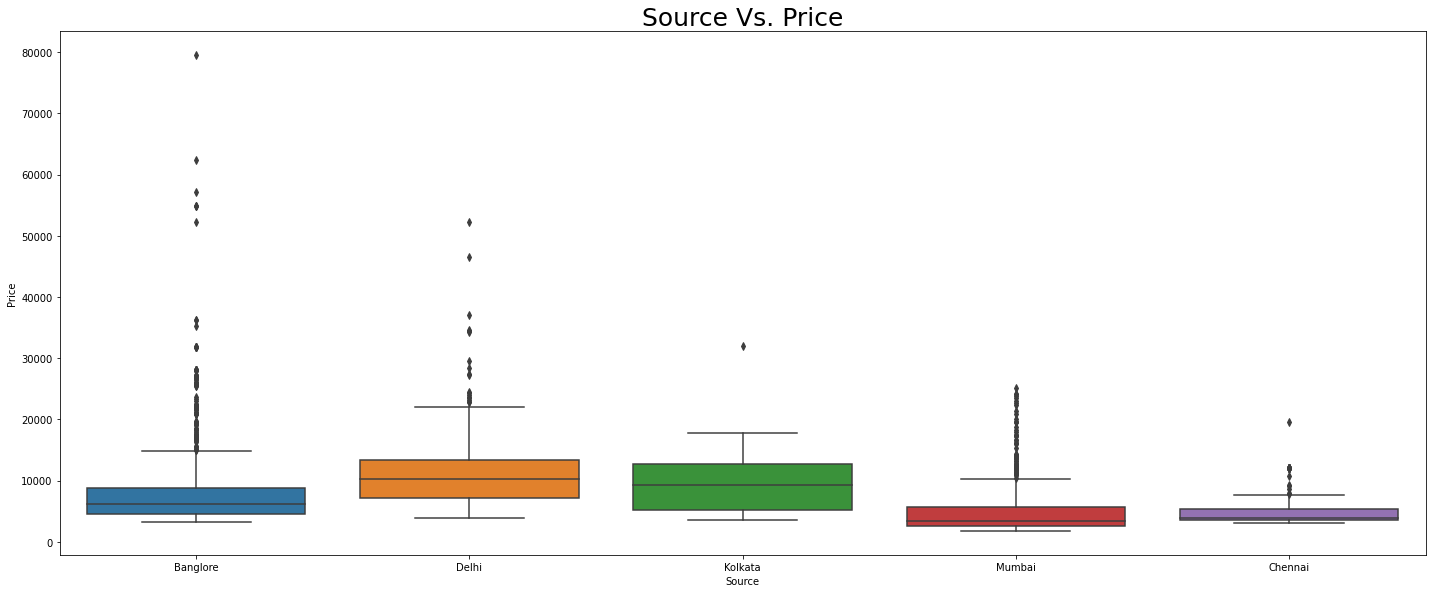

In [38]:
plt.figure(figsize=(20,8))
sns.boxplot(x='Source', y='Price', data = df.sort_values('Price', ascending=False))
plt.tight_layout()
plt.title('Source Vs. Price', fontsize=25)
plt.show()

**Insight:**
- Banglore seems to have the biggest fluctuation in the price
- Delphi has the highest median price compared to other cities in India, so normaly It is the most expensive source
- Mumbai has the lowest median price compared to other cities in India, so normaly It is the cheaper source

In [39]:
source_df = pd.get_dummies(cat_df['Source'], drop_first=True)
source_df.head()

,Chennai,Delhi,Kolkata,Mumbai
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,0


### Destination

In [40]:
cat_df['Destination'].value_counts()

Cochin       4536
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

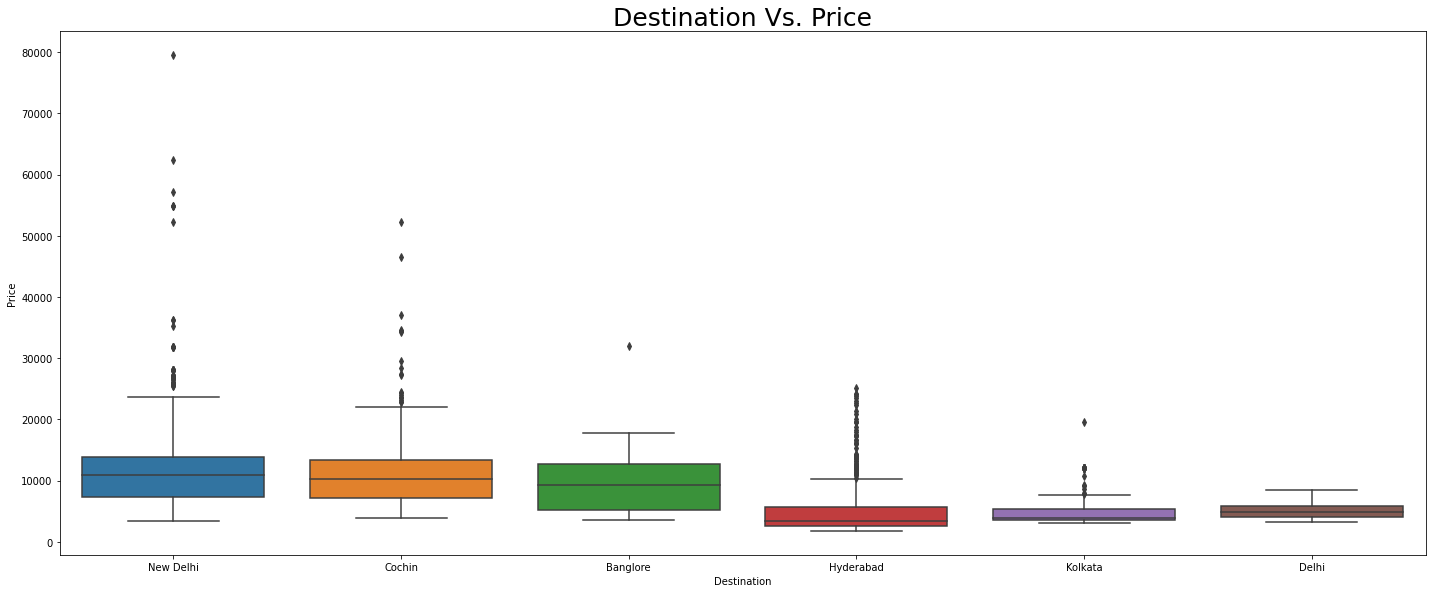

In [41]:
plt.figure(figsize=(20,8))
sns.boxplot(x='Destination', y='Price', data = df.sort_values('Price', ascending=False))
plt.tight_layout()
plt.title('Destination Vs. Price', fontsize=25)
plt.show()

**Insight:**
- New Delphi seems to have the biggest distribution in the price
- New Delphi, Cochin and Banglore have the highest median price compared to other cities in India, so normaly they are the most expensive destination
- Hyderabad has the lowest median price compared to other cities in India, so normaly It is the cheaper destination

In [42]:
destination_df = pd.get_dummies(cat_df['Destination'], drop_first=True)
destination_df.head()

,Cochin,Delhi,Hyderabad,Kolkata,New Delhi
0,0,0,0,0,1
1,0,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,1


### Route

In [43]:
cat_df['Route'].value_counts()

DEL → BOM → COK                2376
BLR → DEL                      1552
CCU → BOM → BLR                 979
CCU → BLR                       724
BOM → HYD                       621
                               ... 
CCU → RPR → HYD → BLR             1
BOM → JLR → HYD                   1
BOM → BLR → CCU → BBI → HYD       1
CCU → IXA → BLR                   1
BLR → HBX → BOM → AMD → DEL       1
Name: Route, Length: 128, dtype: int64

- The longest route is 4 stops so it would be a maximum of 6 divisions.

In [44]:
cat_df[cat_df['Total_Stops'] == 4]

,Airline,Source,Destination,Route,Total_Stops,Additional_Info
9182,Air India,Banglore,New Delhi,BLR → CCU → BBI → HYD → VGA → DEL,4,Change airports


In [45]:
cat_df.loc[:,'Route 1'] = cat_df['Route'].str.split('→').str[0]
cat_df.loc[:,'Route 2'] = cat_df['Route'].str.split('→').str[1]
cat_df.loc[:,'Route 3'] = cat_df['Route'].str.split('→').str[2]
cat_df.loc[:,'Route 4'] = cat_df['Route'].str.split('→').str[3]
cat_df.loc[:,'Route 5'] = cat_df['Route'].str.split('→').str[4]
cat_df.loc[:,'Route 6'] = cat_df['Route'].str.split('→').str[5]
cat_df.drop('Route', axis=1, inplace=True)

In [46]:
cat_df.head()

,Airline,Source,Destination,Total_Stops,Additional_Info,Route 1,Route 2,Route 3,Route 4,Route 5,Route 6
0,IndiGo,Banglore,New Delhi,0,No info,BLR,DEL,NaN,NaN,NaN,NaN
1,Air India,Kolkata,Banglore,2,No info,CCU,IXR,BBI,BLR,NaN,NaN
2,Jet Airways,Delhi,Cochin,2,No info,DEL,LKO,BOM,COK,NaN,NaN
3,IndiGo,Kolkata,Banglore,1,No info,CCU,NAG,BLR,NaN,NaN,NaN
4,IndiGo,Banglore,New Delhi,1,No info,BLR,NAG,DEL,NaN,NaN,NaN


In [47]:
cat_df.isna().sum()

Airline                0
Source                 0
Destination            0
Total_Stops            0
Additional_Info        0
Route 1                0
Route 2                0
Route 3             3491
Route 4             9116
Route 5            10636
Route 6            10681
dtype: int64

In [48]:
for i in ['Route 3', 'Route 4', 'Route 5', 'Route 6']:
    cat_df[i].fillna('None', inplace=True)

In [49]:
cat_df.isna().sum()

Airline            0
Source             0
Destination        0
Total_Stops        0
Additional_Info    0
Route 1            0
Route 2            0
Route 3            0
Route 4            0
Route 5            0
Route 6            0
dtype: int64

In [50]:
cat_df.head()

,Airline,Source,Destination,Total_Stops,Additional_Info,Route 1,Route 2,Route 3,Route 4,Route 5,Route 6
0,IndiGo,Banglore,New Delhi,0,No info,BLR,DEL,None,None,None,None
1,Air India,Kolkata,Banglore,2,No info,CCU,IXR,BBI,BLR,None,None
2,Jet Airways,Delhi,Cochin,2,No info,DEL,LKO,BOM,COK,None,None
3,IndiGo,Kolkata,Banglore,1,No info,CCU,NAG,BLR,None,None,None
4,IndiGo,Banglore,New Delhi,1,No info,BLR,NAG,DEL,None,None,None


In [51]:
encoder = LabelEncoder()
for i in ['Route 1','Route 2','Route 3', 'Route 4', 'Route 5', 'Route 6']:
    cat_df.loc[:,i] = encoder.fit_transform(cat_df.loc[:,i])

In [52]:
cat_df.head()

,Airline,Source,Destination,Total_Stops,Additional_Info,Route 1,Route 2,Route 3,Route 4,Route 5,Route 6
0,IndiGo,Banglore,New Delhi,0,No info,0,13,29,13,5,1
1,Air India,Kolkata,Banglore,2,No info,2,25,1,3,5,1
2,Jet Airways,Delhi,Cochin,2,No info,3,32,4,5,5,1
3,IndiGo,Kolkata,Banglore,1,No info,2,34,3,13,5,1
4,IndiGo,Banglore,New Delhi,1,No info,0,34,8,13,5,1


### Additional_Info

In [53]:
cat_df['Additional_Info'].value_counts()

No info                         8344
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
Red-eye flight                     1
1 Short layover                    1
2 Long layover                     1
Name: Additional_Info, dtype: int64

- As in this feature there are many observations that do not have any information, this column does not give us much information.

In [54]:
cat_df.drop('Additional_Info', axis=1, inplace=True)

In [55]:
cat_df.head()

,Airline,Source,Destination,Total_Stops,Route 1,Route 2,Route 3,Route 4,Route 5,Route 6
0,IndiGo,Banglore,New Delhi,0,0,13,29,13,5,1
1,Air India,Kolkata,Banglore,2,2,25,1,3,5,1
2,Jet Airways,Delhi,Cochin,2,3,32,4,5,5,1
3,IndiGo,Kolkata,Banglore,1,2,34,3,13,5,1
4,IndiGo,Banglore,New Delhi,1,0,34,8,13,5,1


### Join all the categorical dataframes

In [56]:
cat_df = pd.concat([cat_df, airline_df, source_df, destination_df], axis=1)
cat_df.drop('Airline', axis=1, inplace=True)
cat_df.drop('Source', axis=1, inplace=True)
cat_df.drop('Destination', axis=1, inplace=True)

In [57]:
pd.set_option('display.max_columns', 40)
cat_df.head()

,Total_Stops,Route 1,Route 2,Route 3,Route 4,Route 5,Route 6,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Trujet,Vistara,Vistara Premium economy,Chennai,Delhi,Kolkata,Mumbai,Cochin,Delhi,Hyderabad,Kolkata,New Delhi
0,0,0,13,29,13,5,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2,2,25,1,3,5,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2,3,32,4,5,5,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,1,2,34,3,13,5,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1,0,34,8,13,5,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## Continuous features

In [58]:
cont_col = [col for col in df.columns if df[col].dtype != 'O']
cont_col

['Price',
 'journey_day',
 'journey_month',
 'Dep_Time_hour',
 'Dep_Time_minute',
 'Arrival_Time_hour',
 'Arrival_Time_minute',
 'Duration_hours',
 'Duration_mins']

In [59]:
cont_df = df[cont_col]
cont_df.head()

,Price,journey_day,journey_month,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,Duration_hours,Duration_mins
0,3897,24,3,22,20,1,10,2,50
1,7662,5,1,5,50,13,15,7,25
2,13882,6,9,9,25,4,25,19,0
3,6218,5,12,18,5,23,30,5,25
4,13302,3,1,16,50,21,35,4,45


### Join the categorical and continuous dataframes

In [60]:
df = pd.concat([cat_df, cont_df], axis=1)

In [61]:
df.head()

,Total_Stops,Route 1,Route 2,Route 3,Route 4,Route 5,Route 6,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Trujet,Vistara,Vistara Premium economy,Chennai,Delhi,Kolkata,Mumbai,Cochin,Delhi,Hyderabad,Kolkata,New Delhi,Price,journey_day,journey_month,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,Duration_hours,Duration_mins
0,0,0,13,29,13,5,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3897,24,3,22,20,1,10,2,50
1,2,2,25,1,3,5,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,7662,5,1,5,50,13,15,7,25
2,2,3,32,4,5,5,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,13882,6,9,9,25,4,25,19,0
3,1,2,34,3,13,5,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,6218,5,12,18,5,23,30,5,25
4,1,0,34,8,13,5,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,13302,3,1,16,50,21,35,4,45


### Target: Price

In [62]:
df['Price'].describe()

count    10682.000000
mean      9087.214567
std       4611.548810
min       1759.000000
25%       5277.000000
50%       8372.000000
75%      12373.000000
max      79512.000000
Name: Price, dtype: float64

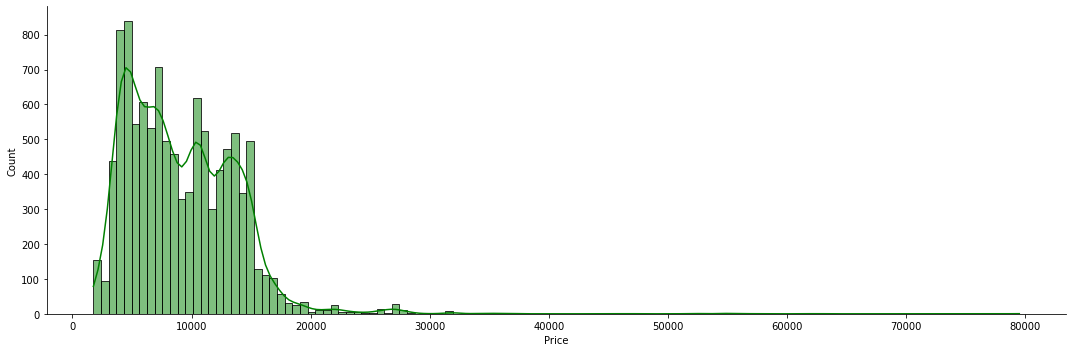

In [63]:
sns.displot(df['Price'], color='g', kde=True, aspect=3)
plt.show()

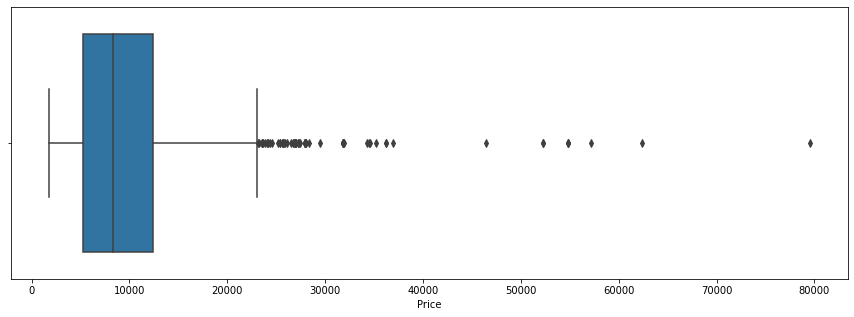

In [64]:
plt.figure(figsize=(15,5))
sns.boxplot(df['Price'])
plt.show()

**Insight:**
- Price doesn't have a normal distribution. It skewed to the right.
- Price has a lot of outliers. According to the information provided any price higher than 40000 is an outlier so we will impute them with the median.

In [65]:
df['Price'] = np.where(df['Price'] >= 40000, df['Price'].median(), df['Price'])

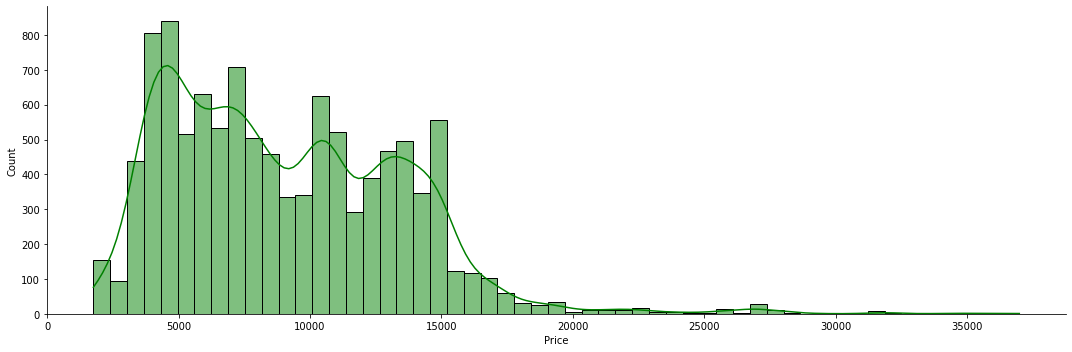

In [66]:
sns.displot(df['Price'], color='g', kde=True, aspect=3)
plt.show()

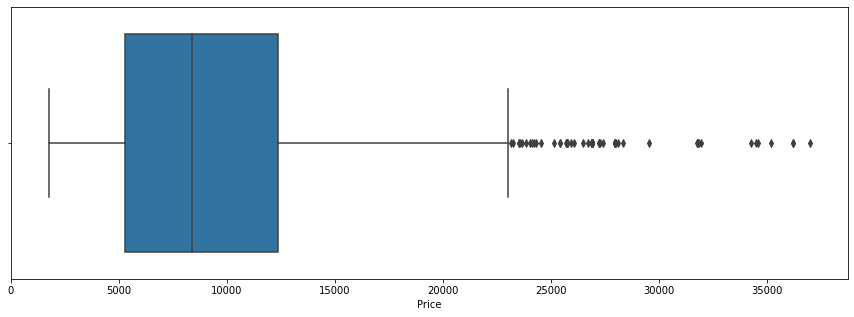

In [67]:
plt.figure(figsize=(15,5))
sns.boxplot(df['Price'])
plt.show()

**Insight:**
- Even if it is skewed to the right we could apply a logarithmic transformation or the square root depending on the result we get in the model.

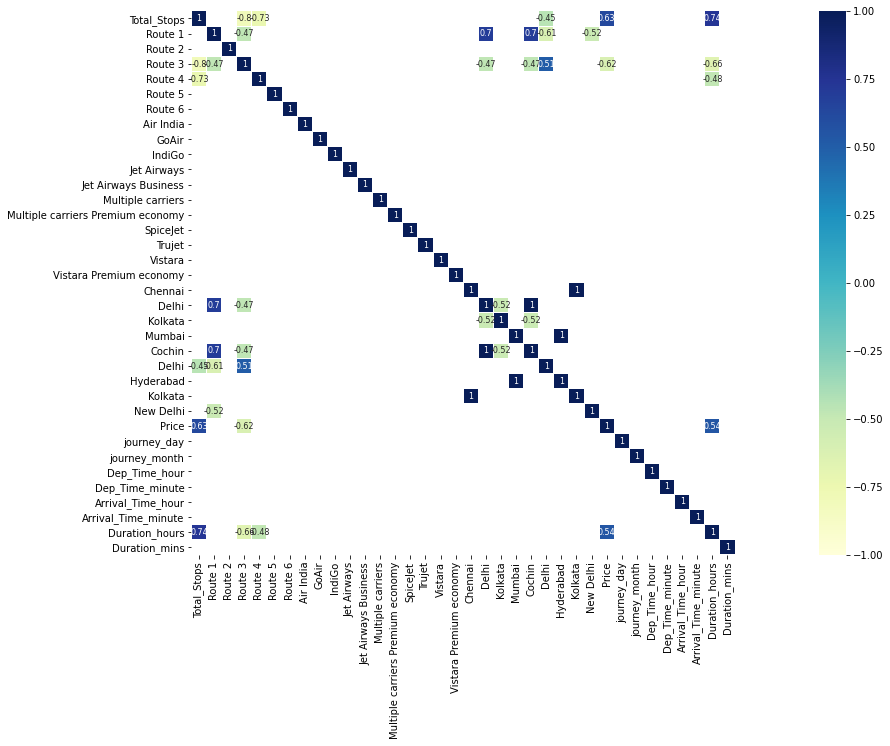

In [68]:
df_corr = df.corr()
plt.figure(figsize=(30,10))
sns.heatmap(df_corr[(df_corr>=0.5) | (df_corr<=-0.4)], cmap="YlGnBu", annot=True, square=True, vmax=1.0, vmin=-1.0, linewidths=0.1, annot_kws={'size':8})
plt.show()

**Insight:**
- The features that have a higher correlation with the price are Tota_Stops, Route_3 and Duration_shours

## Separation between dependent and independent features

### Independet features

In [69]:
X = df.drop('Price', axis=1)

In [70]:
X.head()

,Total_Stops,Route 1,Route 2,Route 3,Route 4,Route 5,Route 6,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Trujet,Vistara,Vistara Premium economy,Chennai,Delhi,Kolkata,Mumbai,Cochin,Delhi,Hyderabad,Kolkata,New Delhi,journey_day,journey_month,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,Duration_hours,Duration_mins
0,0,0,13,29,13,5,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,24,3,22,20,1,10,2,50
1,2,2,25,1,3,5,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,5,1,5,50,13,15,7,25
2,2,3,32,4,5,5,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,6,9,9,25,4,25,19,0
3,1,2,34,3,13,5,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,5,12,18,5,23,30,5,25
4,1,0,34,8,13,5,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,1,16,50,21,35,4,45


### Dependet feature

In [71]:
y = df['Price']
y

0         3897.0
1         7662.0
2        13882.0
3         6218.0
4        13302.0
          ...   
10678     4107.0
10679     4145.0
10680     7229.0
10681    12648.0
10682    11753.0
Name: Price, Length: 10682, dtype: float64

## Feature selection

In [72]:
importance_feature = pd.DataFrame(mutual_info_classif(X,y), index=X.columns)
importance_feature .columns = ['Importance']
importance_feature.sort_values(by='Importance', ascending=False)

,Importance
Route 2,2.786743
Route 3,2.278112
Total_Stops,2.090920
Route 1,2.000094
Arrival_Time_hour,1.829238
Route 6,1.792616
Duration_hours,1.748419
Cochin,1.575091
Arrival_Time_minute,1.552826
Delhi,1.533725


**Insight:**
- The features Multiple carriers Premium economy and Vistara Premium economy doesn't have any effect in the price

### Separation in train and test data

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

## Models

In [74]:
def predict(ml_model):
    model = ml_model.fit(X_train, y_train)
    print('Training Score: {}'.format(model.score(X_train, y_train)))
    print('\n')
    
    predictions = model.predict(X_test)
    print('Predictions are: {}'.format(predictions))
    print('Real values are: {}'.format(y_test.values))
    print('\n')
    
    r2_score = metrics.r2_score(y_test, predictions)
    print('R2 Score is: {}'.format(r2_score))
    print('\n')
    
    print('MAE: {}'.format(metrics.mean_absolute_error(y_test, predictions)))
    print('MSE: {}'.format(metrics.mean_squared_error(y_test, predictions)))
    print('RMSE: {}'.format(np.sqrt(metrics.mean_absolute_error(y_test, predictions))))
    
    sns.displot(y_test-predictions)

### Model: RandomForestRegressor

Training Score: 0.9537457724257219


Predictions are: [12997.41666667  5726.76       12952.32833333 ... 11862.86
  2191.268      10347.15283333]
Real values are: [ 8930.  5192. 13344. ... 11642.  1759. 13587.]


R2 Score is: 0.8226593970628435


MAE: 1177.1364750979276
MSE: 3692468.4104818385
RMSE: 34.30942254101528


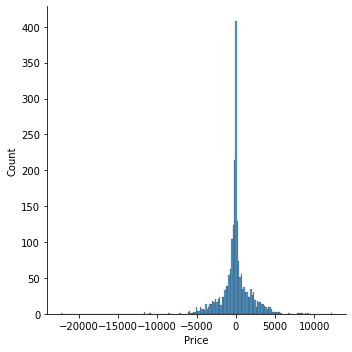

In [75]:
predict(RandomForestRegressor())

### Model: LinearRegression

In [76]:
# predict(LinearRegression())

### Model: DecisionTreeRegressor

Training Score: 0.9668036011089702


Predictions are: [13587.  5192. 14714. ... 11642.  2201.  7153.]
Real values are: [ 8930.  5192. 13344. ... 11642.  1759. 13587.]


R2 Score is: 0.7202783323715254


MAE: 1362.4548432381844
MSE: 5824179.0336725935
RMSE: 36.911445965149944


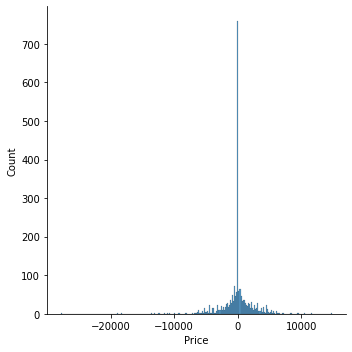

In [77]:
predict(DecisionTreeRegressor())

### Model: KNeighborsRegressor

Training Score: 0.7813169453353845


Predictions are: [12855.2  5541.2 14368.8 ... 12119.   2028.6 11722.8]
Real values are: [ 8930.  5192. 13344. ... 11642.  1759. 13587.]


R2 Score is: 0.639553734217416


MAE: 1807.6019653720168
MSE: 7504973.074609265
RMSE: 42.51590249979432


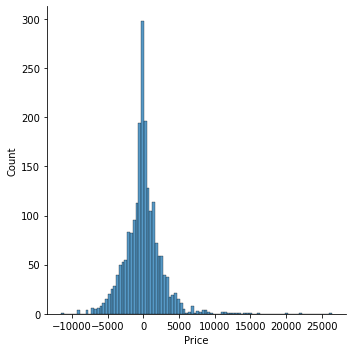

In [78]:
predict(KNeighborsRegressor())

**Insight:**
- The model with the best performace is RandomForestRegressor with:
    - Training Score: 0.9537457724257219
    - R2 Score is: 0.8226593970628435
    - MAE: 1177.1364750979276
    - MSE: 3692468.4104818385
    - RMSE: 34.30942254101528

#### Optimization of RandomForestRegressor

In [79]:
n_estimators = [int(x) for x in np.linspace(start=100, stop=1200, num=6)]
max_depth = [int(x) for x in np.linspace(start=5, stop=30, num=4)]

In [80]:
random_grid = {
    'n_estimators': n_estimators,
    'max_features': ['auto', 'sqrt'],
    'max_depth': max_depth,
    'min_samples_split': [5,10,15,100]
}

In [81]:
reg_rf = RandomForestRegressor()
reg_rg_grid = RandomizedSearchCV(estimator=reg_rf, param_distributions=random_grid, cv=3, verbose=2, n_jobs=-1)

In [82]:
reg_rg_grid.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.0min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 13, 21, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [5, 10, 15, 100],
                                        'n_estimators': [100, 320, 540, 760,
                                                         980, 1200]},
                   verbose=2)

In [83]:
reg_rg_grid.best_params_

{'n_estimators': 540,
 'min_samples_split': 10,
 'max_features': 'auto',
 'max_depth': 13}

Training Score: 0.9112525190923474


Predictions are: [11442.06672303  5877.07930448 13071.46833297 ... 12060.40465273
  2165.64284109 11290.01244157]
Real values are: [ 8930.  5192. 13344. ... 11642.  1759. 13587.]


R2 Score is: 0.8497925167411061


MAE: 1138.8695359580047
MSE: 3127520.5889989543
RMSE: 33.7471411523703


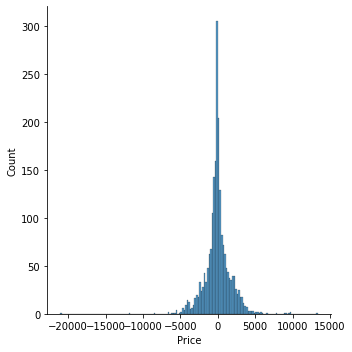

In [84]:
print('Training Score: {}'.format(reg_rg_grid.score(X_train, y_train)))
print('\n')
    
predictions = reg_rg_grid.predict(X_test)
print('Predictions are: {}'.format(predictions))
print('Real values are: {}'.format(y_test.values))
print('\n')
    
r2_score = metrics.r2_score(y_test, predictions)
print('R2 Score is: {}'.format(r2_score))
print('\n')
    
print('MAE: {}'.format(metrics.mean_absolute_error(y_test, predictions)))
print('MSE: {}'.format(metrics.mean_squared_error(y_test, predictions)))
print('RMSE: {}'.format(np.sqrt(metrics.mean_absolute_error(y_test, predictions))))

sns.displot(y_test - predictions)

**Insight:**
- Using Gridsearch we got a better performance of the model:
    - Training Score: 0.9101933777567657
    - R2 Score is: 0.8494026988271748
    - MAE: 1122.6750493300422
    - MSE: 3135637.1190501195
    - RMSE: 33.50634341926976       

#### Transforming target feature

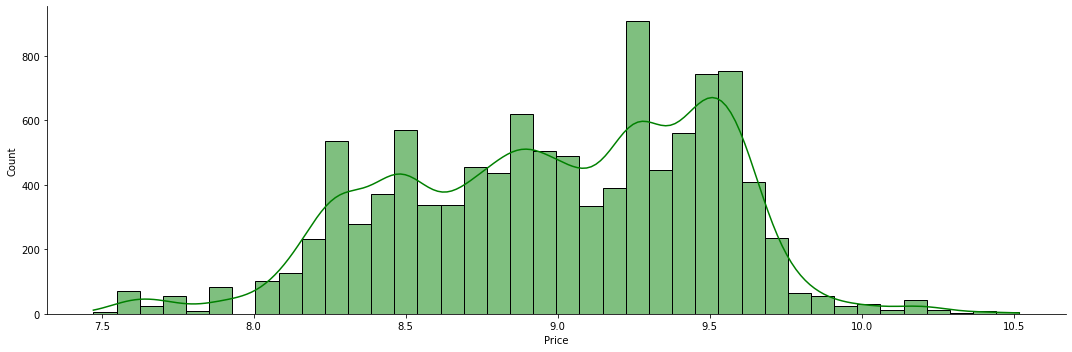

In [85]:
sns.displot(np.log(df['Price']), color='g', kde=True, aspect=3)
plt.show()

In [86]:
reg_rf = RandomForestRegressor()
reg_rg_grid = RandomizedSearchCV(estimator=reg_rf, param_distributions=random_grid, cv=3, verbose=2, n_jobs=-1)

In [87]:
reg_rg_grid.fit(X_train, np.log(y_train))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.4min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 13, 21, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [5, 10, 15, 100],
                                        'n_estimators': [100, 320, 540, 760,
                                                         980, 1200]},
                   verbose=2)

In [88]:
reg_rg_grid.best_params_

{'n_estimators': 980,
 'min_samples_split': 5,
 'max_features': 'auto',
 'max_depth': 21}

Training Score: 0.9542976987075716


Predictions are: [9.40021556 8.62395581 9.4397395  ... 9.38032216 7.65886184 9.21544707]
Real values are: [9.09717167 8.55487426 9.49882212 ... 9.36237453 7.47250074 9.51686873]


R2 Score is: 0.881857662264481


MAE: 9114.740874458246
MSE: 103895807.09060062
RMSE: 95.47115205368712


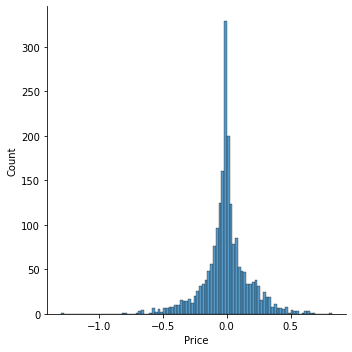

In [89]:
print('Training Score: {}'.format(reg_rg_grid.score(X_train, np.log(y_train))))
print('\n')
    
predictions = reg_rg_grid.predict(X_test)
print('Predictions are: {}'.format(predictions))
print('Real values are: {}'.format(np.log(y_test).values))
print('\n')
    
r2_score = metrics.r2_score(np.log(y_test), predictions)
print('R2 Score is: {}'.format(r2_score))
print('\n')
    
print('MAE: {}'.format(metrics.mean_absolute_error(y_test, predictions)))
print('MSE: {}'.format(metrics.mean_squared_error(y_test, predictions)))
print('RMSE: {}'.format(np.sqrt(metrics.mean_absolute_error(y_test, predictions))))

sns.displot(np.log(y_test) - predictions)

**Insight:**
- Applying GridSearch and log in Price we got a better performance in the R2 score:
    - Training Score:  0.9542976987075716
    - R2 Score is: 0.881857662264481
    - MAE: 9114.740874458246
    - MSE: 103895807.09060062
    - RMSE: 95.47115205368712